In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os, sys
import scipy.integrate as spi
import matplotlib

CURRENT_DIR = os.getcwd()
module_path = os.path.abspath(os.path.join(CURRENT_DIR, "../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from Anydim_transferability.GNN.model import GNN
from Anydim_transferability.GNN import color_dict
from Anydim_transferability import typesetting

typesetting()

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[ 10  15  25  39  63  99 158 251 398 630]


/tmp/ipykernel_1056452/4241472553.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


KeyError: 'IGN'

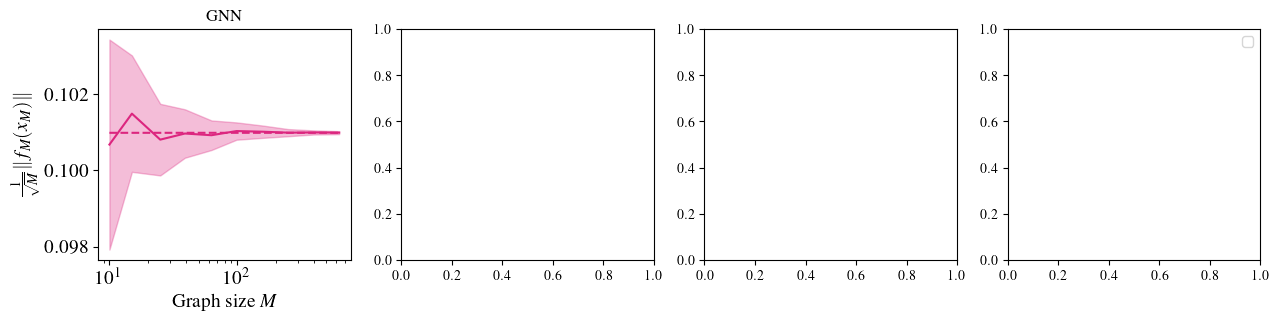

In [2]:
# gaussian feature, bernoulli ER graph
torch.manual_seed(10)


def generate_ER(N, n):
    p = 1 / 2
    adj_matrix = np.random.binomial(1, p, (N, n, n))
    adj_matrix = np.triu(adj_matrix, 0) + np.triu(adj_matrix, 1).transpose(0, 2, 1)
    x = np.ones((N, n, 1))
    return adj_matrix, x


def generate_constant_graphon(N, n):
    adj_matrix = np.ones((N, n, n), dtype=np.float32) * 1 / 2
    adj_matrix = np.triu(adj_matrix, 0) + np.triu(adj_matrix, 1).transpose(0, 2, 1)
    x = np.ones((N, n, 1))
    return adj_matrix, x


n_samples = 100
log_n_range = np.arange(1, 3, 0.2)
# for _ in range(5):
# fix 3 models with random weights
gnn_simple = GNN(channel_list=[1, 1], model="simple")
ptwise_compatible = GNN(
    channel_list=[1, 1],
    model="ign_anydim",
)
ptwise_incompatible = GNN(channel_list=[1, 5, 5, 1], model="ign")
gnn_reduced = GNN(channel_list=[1, 5, 5, 1], model="reduced")
gnn_unreduced = GNN(channel_list=[1, 5, 5, 1], model="unreduced")

# compute output
n_range = np.power(10, log_n_range).astype(int)
print(n_range)
models = {
    "GNN": gnn_simple,
    "IGN": ptwise_incompatible,
    "GNN-compatible": gnn_unreduced,
    "GNN-compatible-continuous": gnn_reduced,
}
outputs_ER = {}
outputs_constant = {}
for model_name, model in models.items():
    model.eval()
    outputs_ER.setdefault(model_name, [])
    outputs_constant.setdefault(model_name, [])
    for i, n in enumerate(n_range):
        A_ER, X_ER = generate_ER(n_samples, n)
        A_constant, X_constant = generate_constant_graphon(n_samples, n)
        with torch.no_grad():
            output_ER = model(torch.Tensor(A_ER), torch.Tensor(X_ER))
            output_constant = model(torch.Tensor(A_constant), torch.Tensor(X_constant))
            outputs_ER[model_name].append(output_ER)
            outputs_constant[model_name].append(output_constant)

# plot
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for ax, model_name in zip(axs, models.keys()):
    norms_of_outputs_ER = [
        torch.norm(outputs_ER[model_name][i].squeeze(), dim=-1) / np.sqrt(n)
        for i, n in enumerate(n_range)
    ]
    norms_of_outputs_constant = [
        torch.norm(outputs_constant[model_name][i].squeeze(), dim=-1) / np.sqrt(n)
        for i, n in enumerate(n_range)
    ]
    ax.plot(
        n_range,
        [norms_of_outputs_ER[i].mean() for i in range(len(n_range))],
        label=r"Erdos Renyi $p=1/2$",
        color=color_dict[model_name],
    )
    ax.fill_between(
        n_range,
        [norms_of_outputs_ER[i].mean() - norms_of_outputs_ER[i].std() for i in range(len(n_range))],
        [norms_of_outputs_ER[i].mean() + norms_of_outputs_ER[i].std() for i in range(len(n_range))],
        color=color_dict[model_name],
        alpha=0.3,
    )
    ax.plot(
        n_range,
        [norms_of_outputs_constant[i].mean() for i in range(len(n_range))],
        label=r"Fully connected $w=1/2$",
        color=color_dict[model_name],
        linestyle="--",
    )
    ax.set_xscale("log")
    ax.set_xlabel("Graph size $M$", fontsize=14)
    ax.set_ylabel(r"$\frac{1}{\sqrt{M}} \|f_M(x_M)\|$", fontsize=14)
    ax.set_title(model_name, fontsize=12)
    ax.tick_params(axis="both", which="major", labelsize=14)
    plt.legend()

plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/gnn_transferability_outputs.pdf")
plt.show()

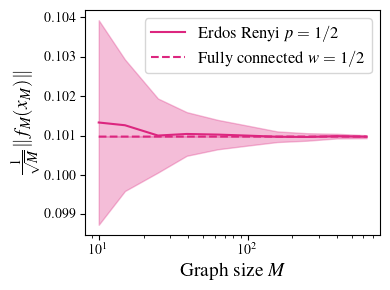

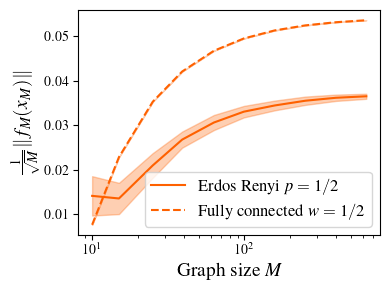

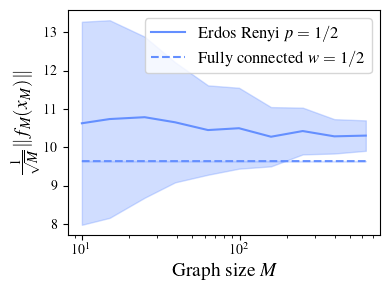

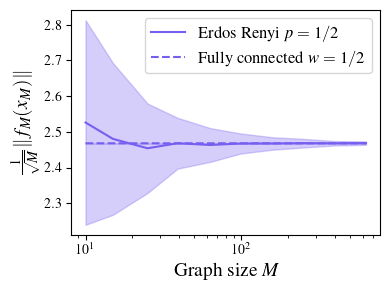

In [ ]:
for model_name, color in color_dict.items():
    plt.figure(figsize=(4, 3))
    norms_of_outputs_ER = [
        torch.norm(outputs_ER[model_name][i].squeeze(), dim=-1) / np.sqrt(n)
        for i, n in enumerate(n_range)
    ]
    norms_of_outputs_constant = [
        torch.norm(outputs_constant[model_name][i].squeeze(), dim=-1) / np.sqrt(n)
        for i, n in enumerate(n_range)
    ]
    plt.plot(
        n_range,
        [norms_of_outputs_ER[i].mean() for i in range(len(n_range))],
        label=r"Erdos Renyi $p=1/2$",
        color=color,
    )
    plt.fill_between(
        n_range,
        [norms_of_outputs_ER[i].mean() - norms_of_outputs_ER[i].std() for i in range(len(n_range))],
        [norms_of_outputs_ER[i].mean() + norms_of_outputs_ER[i].std() for i in range(len(n_range))],
        color=color,
        alpha=0.3,
    )
    plt.plot(
        n_range,
        [norms_of_outputs_constant[i].mean() for i in range(len(n_range))],
        label=r"Fully connected $w=1/2$",
        color=color,
        linestyle="--",
    )
    plt.fill_between(
        n_range,
        [
            norms_of_outputs_constant[i].mean() - norms_of_outputs_constant[i].std()
            for i in range(len(n_range))
        ],
        [
            norms_of_outputs_constant[i].mean() + norms_of_outputs_constant[i].std()
            for i in range(len(n_range))
        ],
        color=color,
        alpha=0.3,
    )
    plt.xscale("log")
    plt.xlabel("Graph size $M$", fontsize=14)
    plt.ylabel(r"$\frac{1}{\sqrt{M}} \|f_M(x_M)\|$", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(
        CURRENT_DIR
        + f"/log/transferability/{model_name.lower().replace(' ', '_')}_transferability_outputs.pdf"
    )
    plt.show()